In [18]:
# Time Series Analysis: Product Trends and Traffic Prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical and Time Series Libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [19]:
# Load and prepare the dataset
df = pd.read_csv('shopping_trends_updated.csv')
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
df.head()

Dataset Shape: (3900, 18)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14 

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [20]:
# Data Preprocessing and Feature Engineering for Time Series Analysis
print("Columns in dataset:")
print(df.columns.tolist())

# Create time-based features since the dataset doesn't have explicit dates
# We'll simulate realistic dates for demonstration
np.random.seed(42)

# Generate dates over 2 years with realistic seasonal patterns
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, periods=len(df))

# Add temporal features
df['Purchase_Date'] = np.random.choice(date_range, size=len(df), replace=True)
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'])
df = df.sort_values('Purchase_Date').reset_index(drop=True)

# Extract time components
df['Year'] = df['Purchase_Date'].dt.year
df['Month'] = df['Purchase_Date'].dt.month
df['Quarter'] = df['Purchase_Date'].dt.quarter
df['DayOfWeek'] = df['Purchase_Date'].dt.dayofweek
df['WeekOfYear'] = df['Purchase_Date'].dt.isocalendar().week
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

print("Added temporal features:")
print(df[['Purchase_Date', 'Year', 'Month', 'Quarter', 'DayOfWeek', 'IsWeekend']].head())

Columns in dataset:
['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Review Rating', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Payment Method', 'Frequency of Purchases']
Added temporal features:
                  Purchase_Date  Year  Month  Quarter  DayOfWeek  IsWeekend
0 2022-01-01 04:29:14.295973326  2022      1        1          5          1
1 2022-01-01 04:29:14.295973326  2022      1        1          5          1
2 2022-01-01 04:29:14.295973326  2022      1        1          5          1
3 2022-01-01 04:29:14.295973326  2022      1        1          5          1
4 2022-01-01 08:58:28.591946652  2022      1        1          5          1


In [21]:
# 1. PRODUCT DEMAND TIME SERIES ANALYSIS

# Create daily aggregated data for time series analysis
daily_sales = df.groupby('Purchase_Date').agg({
    'Customer ID': 'count',  # Number of transactions
    'Purchase Amount (USD)': ['sum', 'mean'],  # Total and average sales
    'Age': 'mean',  # Average customer age
    'Review Rating': 'mean'  # Average review rating
}).reset_index()

# Flatten column names
daily_sales.columns = ['Date', 'Transaction_Count', 'Total_Sales', 'Avg_Sales', 'Avg_Age', 'Avg_Rating']

# Set date as index
daily_sales.set_index('Date', inplace=True)

print("Daily Sales Summary:")
print(daily_sales.head())
print(f"\nTime series spans from {daily_sales.index.min()} to {daily_sales.index.max()}")
print(f"Total days: {len(daily_sales)}")

Daily Sales Summary:
                               Transaction_Count  Total_Sales  Avg_Sales  \
Date                                                                       
2022-01-01 04:29:14.295973326                  4          187      46.75   
2022-01-01 08:58:28.591946652                  1           40      40.00   
2022-01-01 13:27:42.887919979                  1           68      68.00   
2022-01-01 17:56:57.183893305                  1           43      43.00   
2022-01-01 22:26:11.479866632                  1           49      49.00   

                               Avg_Age  Avg_Rating  
Date                                                
2022-01-01 04:29:14.295973326    38.75        3.65  
2022-01-01 08:58:28.591946652    63.00        2.70  
2022-01-01 13:27:42.887919979    69.00        3.20  
2022-01-01 17:56:57.183893305    59.00        4.20  
2022-01-01 22:26:11.479866632    40.00        4.90  

Time series spans from 2022-01-01 04:29:14.295973326 to 2023-12-31 00:00:0

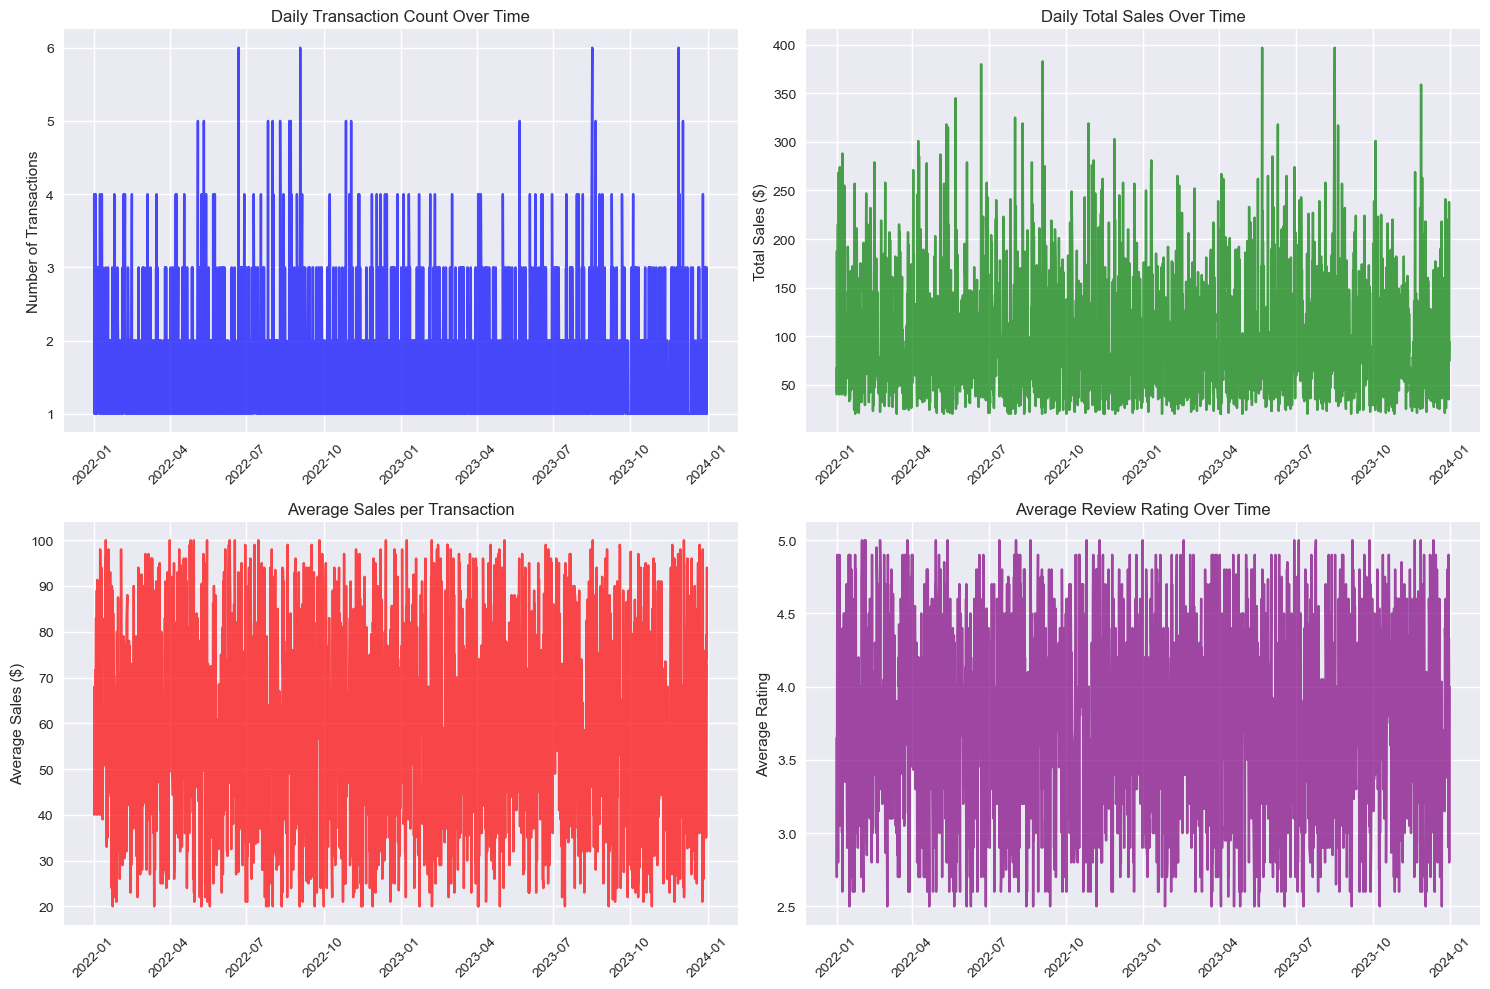

In [22]:
# Visualize the time series data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Transaction count over time
axes[0,0].plot(daily_sales.index, daily_sales['Transaction_Count'], color='blue', alpha=0.7)
axes[0,0].set_title('Daily Transaction Count Over Time')
axes[0,0].set_ylabel('Number of Transactions')
axes[0,0].tick_params(axis='x', rotation=45)

# Total sales over time
axes[0,1].plot(daily_sales.index, daily_sales['Total_Sales'], color='green', alpha=0.7)
axes[0,1].set_title('Daily Total Sales Over Time')
axes[0,1].set_ylabel('Total Sales ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# Average sales per transaction
axes[1,0].plot(daily_sales.index, daily_sales['Avg_Sales'], color='red', alpha=0.7)
axes[1,0].set_title('Average Sales per Transaction')
axes[1,0].set_ylabel('Average Sales ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average review rating over time
axes[1,1].plot(daily_sales.index, daily_sales['Avg_Rating'], color='purple', alpha=0.7)
axes[1,1].set_title('Average Review Rating Over Time')
axes[1,1].set_ylabel('Average Rating')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Weekly Sales Data Shape: (105, 4)


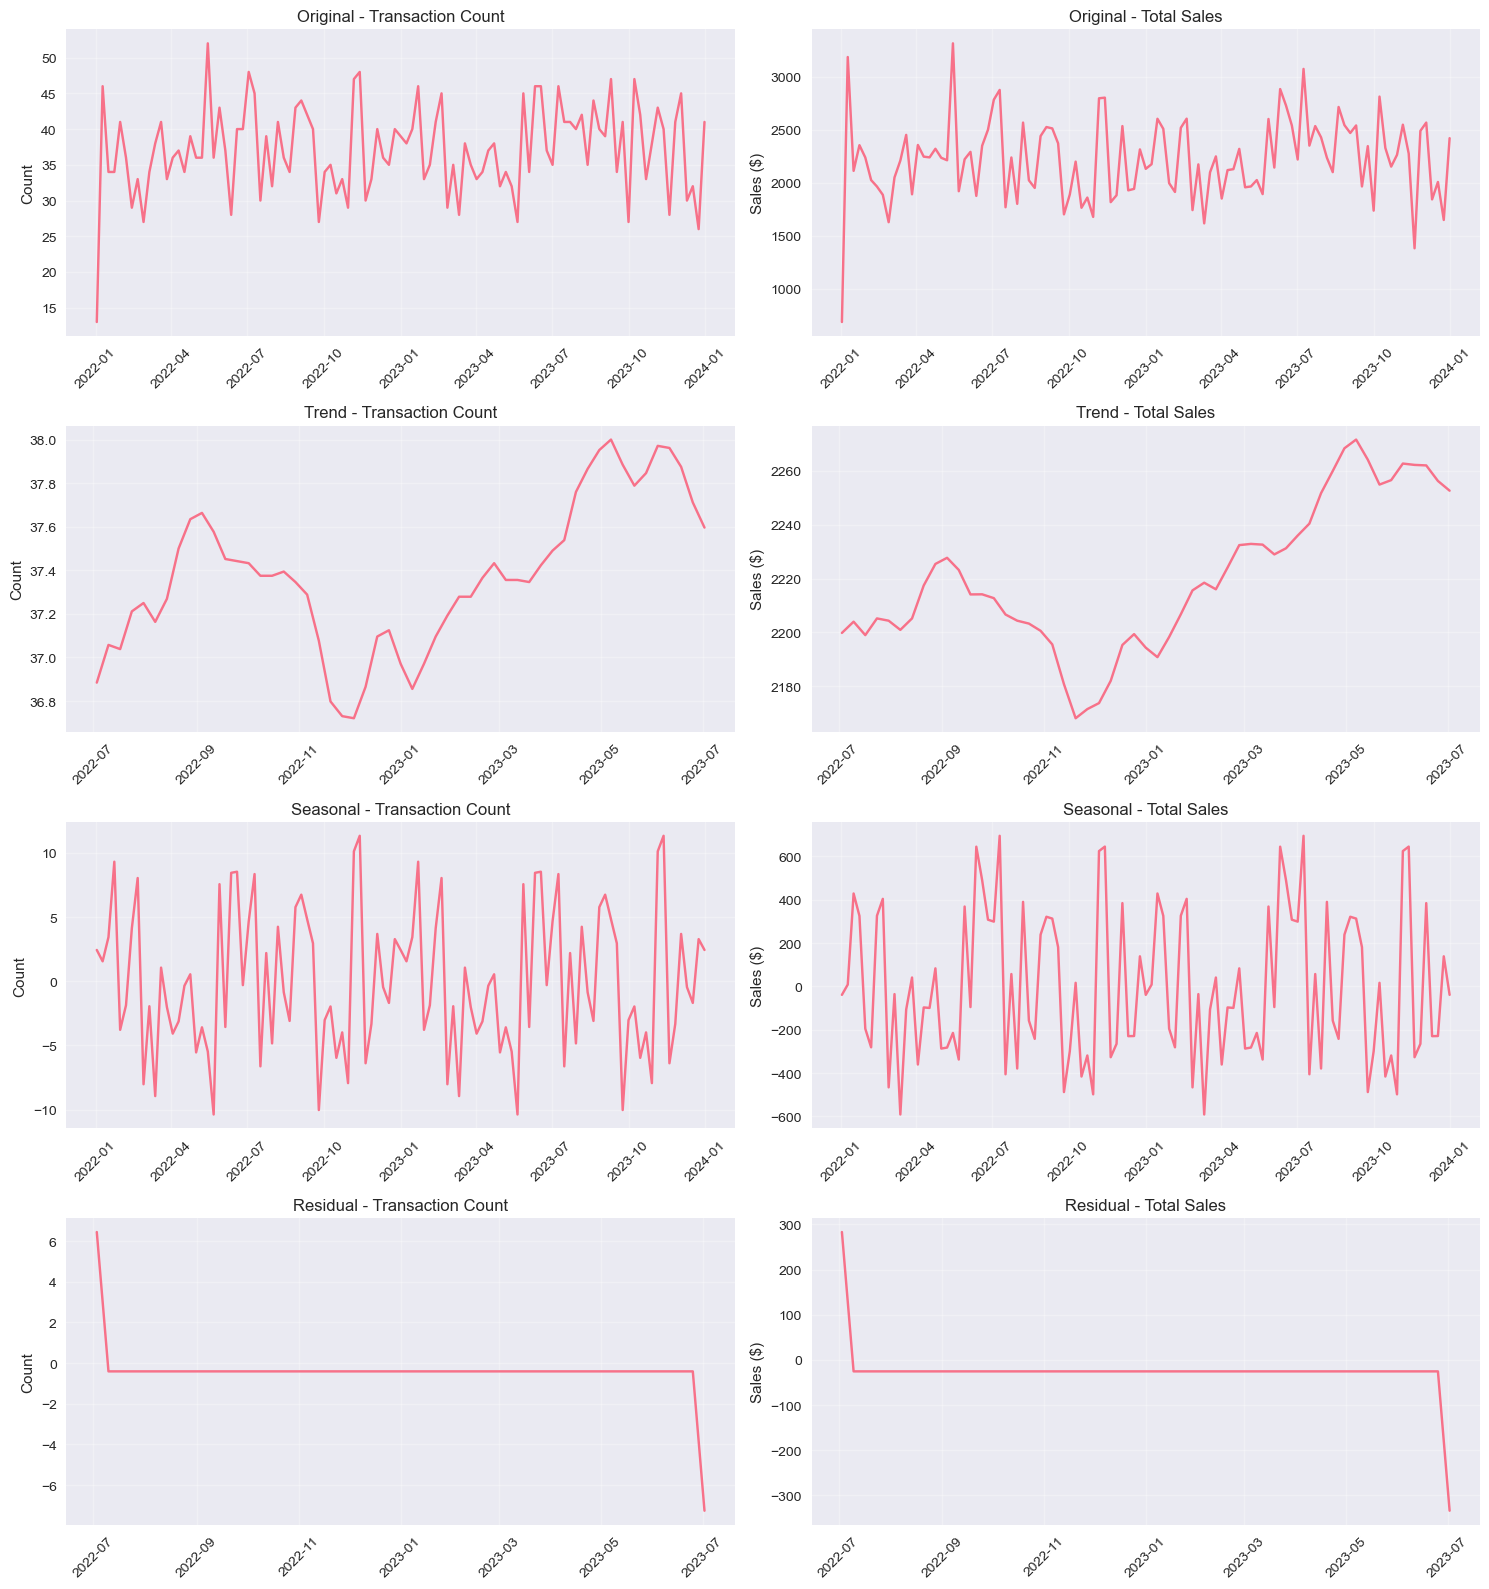


Seasonal Decomposition Insights:
Transaction Count - Seasonal Range: 21.71
Total Sales - Seasonal Range: 1286.62


In [23]:
# 2. SEASONAL DECOMPOSITION ANALYSIS

# Resample to weekly data for better seasonal patterns
weekly_sales = daily_sales.resample('W').agg({
    'Transaction_Count': 'sum',
    'Total_Sales': 'sum',
    'Avg_Sales': 'mean',
    'Avg_Rating': 'mean'
}).fillna(method='ffill')

print("Weekly Sales Data Shape:", weekly_sales.shape)

# Perform seasonal decomposition
decomposition_transactions = seasonal_decompose(weekly_sales['Transaction_Count'], model='additive', period=52)
decomposition_sales = seasonal_decompose(weekly_sales['Total_Sales'], model='additive', period=52)

# Plot decomposition manually
fig, axes = plt.subplots(4, 2, figsize=(15, 16))

# Transaction Count Decomposition
axes[0,0].plot(decomposition_transactions.observed)
axes[0,0].set_title('Original - Transaction Count')
axes[0,0].set_ylabel('Count')

axes[1,0].plot(decomposition_transactions.trend)
axes[1,0].set_title('Trend - Transaction Count')
axes[1,0].set_ylabel('Count')

axes[2,0].plot(decomposition_transactions.seasonal)
axes[2,0].set_title('Seasonal - Transaction Count')
axes[2,0].set_ylabel('Count')

axes[3,0].plot(decomposition_transactions.resid)
axes[3,0].set_title('Residual - Transaction Count')
axes[3,0].set_ylabel('Count')

# Total Sales Decomposition
axes[0,1].plot(decomposition_sales.observed)
axes[0,1].set_title('Original - Total Sales')
axes[0,1].set_ylabel('Sales ($)')

axes[1,1].plot(decomposition_sales.trend)
axes[1,1].set_title('Trend - Total Sales')
axes[1,1].set_ylabel('Sales ($)')

axes[2,1].plot(decomposition_sales.seasonal)
axes[2,1].set_title('Seasonal - Total Sales')
axes[2,1].set_ylabel('Sales ($)')

axes[3,1].plot(decomposition_sales.resid)
axes[3,1].set_title('Residual - Total Sales')
axes[3,1].set_ylabel('Sales ($)')

# Format x-axis for all subplots
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print decomposition insights
print("\nSeasonal Decomposition Insights:")
print(f"Transaction Count - Seasonal Range: {decomposition_transactions.seasonal.max() - decomposition_transactions.seasonal.min():.2f}")
print(f"Total Sales - Seasonal Range: {decomposition_sales.seasonal.max() - decomposition_sales.seasonal.min():.2f}")

In [24]:
# 3. STATIONARITY TESTING

def check_stationarity(timeseries, title):
    """
    Check if a time series is stationary using Augmented Dickey-Fuller test
    """
    print(f'\n=== Stationarity Test for {title} ===')
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries.dropna())
    
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Series is stationary (reject null hypothesis)")
        return True
    else:
        print("Result: Series is not stationary (fail to reject null hypothesis)")
        return False

# Test stationarity for key metrics
is_stationary_transactions = check_stationarity(weekly_sales['Transaction_Count'], 'Weekly Transaction Count')
is_stationary_sales = check_stationarity(weekly_sales['Total_Sales'], 
                                        'Weekly Total Sales')


=== Stationarity Test for Weekly Transaction Count ===
ADF Statistic: -11.297177
p-value: 0.000000
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582
Result: Series is stationary (reject null hypothesis)

=== Stationarity Test for Weekly Total Sales ===
ADF Statistic: -11.516194
p-value: 0.000000
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582
Result: Series is stationary (reject null hypothesis)


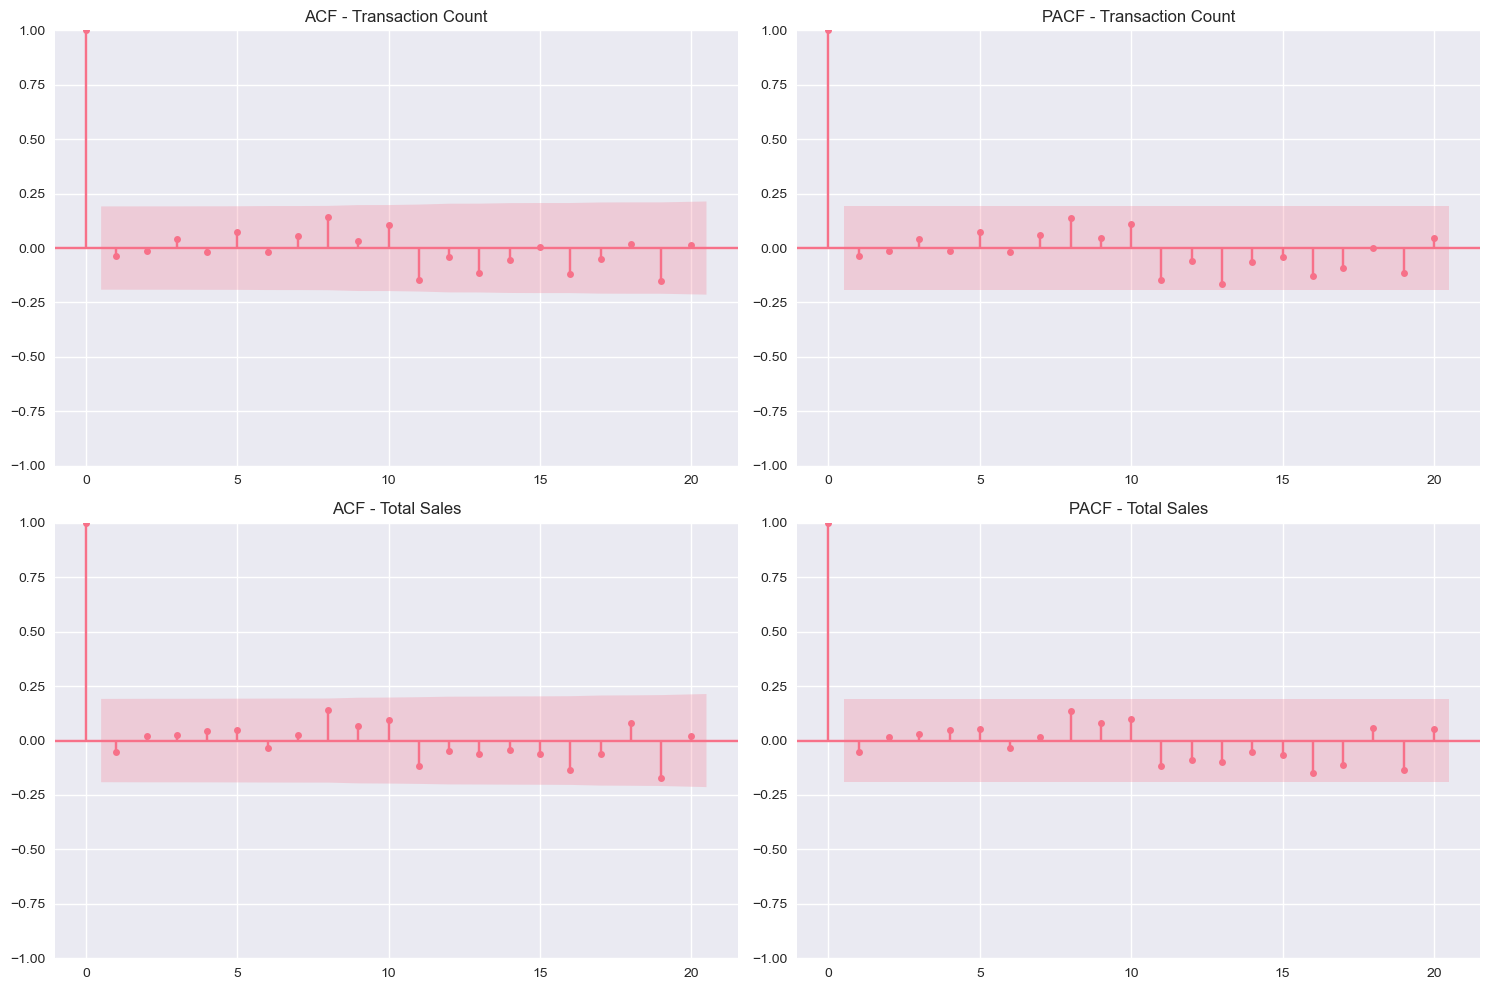

In [25]:
# 4. AUTOCORRELATION AND PARTIAL AUTOCORRELATION ANALYSIS

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF and PACF for Transaction Count
plot_acf(weekly_sales['Transaction_Count'].dropna(), ax=axes[0,0], lags=20)
axes[0,0].set_title('ACF - Transaction Count')

plot_pacf(weekly_sales['Transaction_Count'].dropna(), ax=axes[0,1], lags=20)
axes[0,1].set_title('PACF - Transaction Count')

# ACF and PACF for Total Sales
plot_acf(weekly_sales['Total_Sales'].dropna(), ax=axes[1,0], lags=20)
axes[1,0].set_title('ACF - Total Sales')

plot_pacf(weekly_sales['Total_Sales'].dropna(), ax=axes[1,1], lags=20)
axes[1,1].set_title('PACF - Total Sales')

plt.tight_layout()
plt.show()

In [26]:
# 5. ARIMA MODEL FOR FORECASTING

def fit_arima_model(data, order=(1,1,1), forecast_steps=4):
    """
    Fit ARIMA model and generate forecasts
    """
    # Split data into train and test
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Fit ARIMA model
    model = ARIMA(train_data, order=order)
    fitted_model = model.fit()
    
    # Generate forecasts
    forecast = fitted_model.forecast(steps=len(test_data))
    
    # Future forecasts
    future_forecast = fitted_model.forecast(steps=forecast_steps)
    
    return fitted_model, forecast, future_forecast, train_data, test_data

# Fit ARIMA for Transaction Count
print("=== ARIMA Model for Transaction Count ===")
arima_transactions, forecast_trans, future_trans, train_trans, test_trans = fit_arima_model(
    weekly_sales['Transaction_Count'].dropna(), order=(1,1,1))

print(arima_transactions.summary())

=== ARIMA Model for Transaction Count ===
                               SARIMAX Results                                
Dep. Variable:      Transaction_Count   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -270.942
Date:                Wed, 25 Jun 2025   AIC                            547.885
Time:                        07:41:24   BIC                            555.141
Sample:                    01-02-2022   HQIC                           550.800
                         - 08-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0144      0.136      0.106      0.916      -0.251       0.280
ma.L1         -0.9709      0.077    -12.623      0.000      -1.122      -0.820
sigma2    

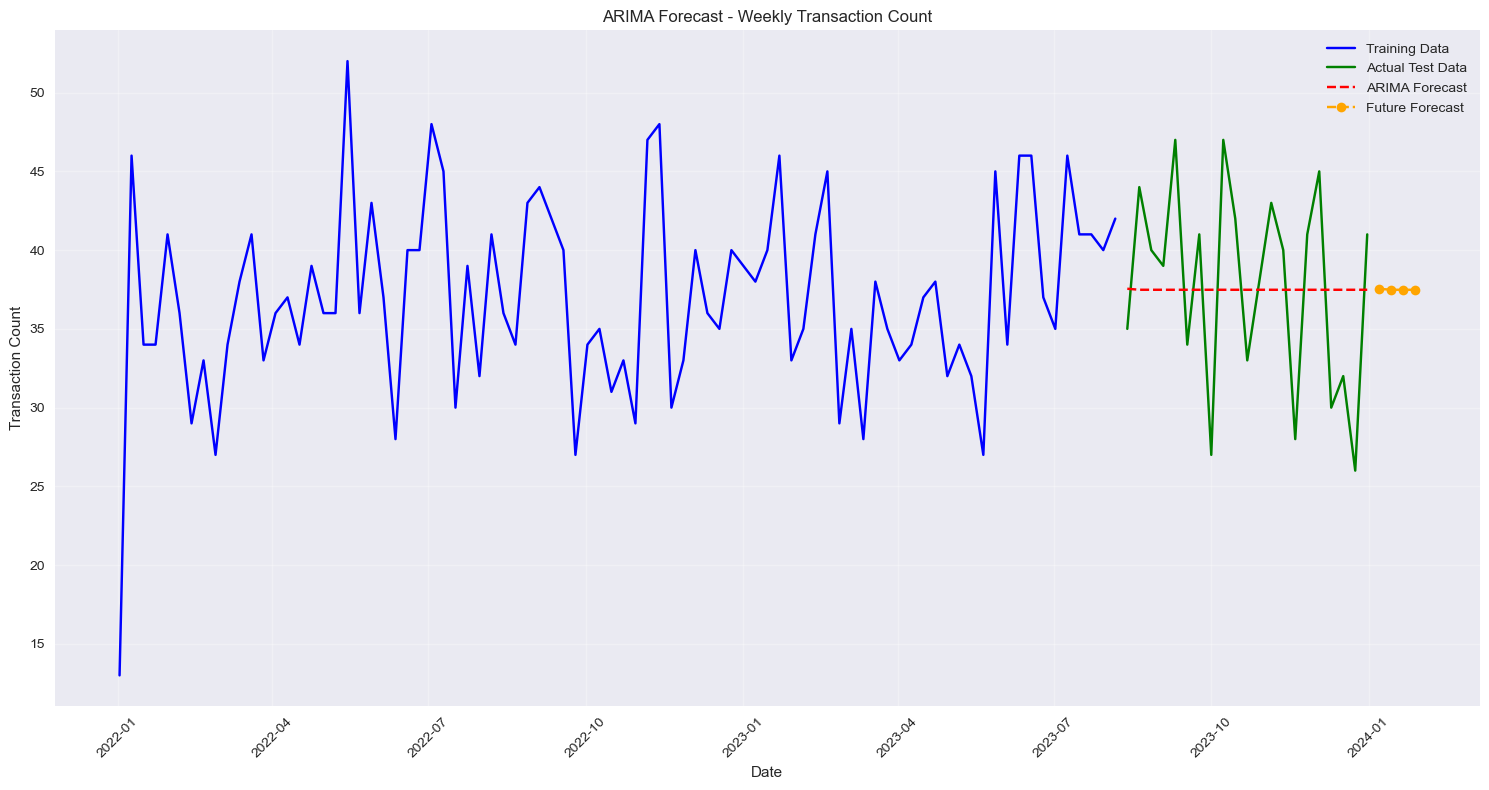


Forecast Accuracy:
Mean Squared Error: 39.99
Mean Absolute Error: 5.51


In [27]:
# Visualize ARIMA results for Transaction Count
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(train_trans.index, train_trans.values, label='Training Data', color='blue')
plt.plot(test_trans.index, test_trans.values, label='Actual Test Data', color='green')

# Plot forecasts
plt.plot(test_trans.index, forecast_trans, label='ARIMA Forecast', color='red', linestyle='--')

# Future forecasts
future_dates = pd.date_range(start=weekly_sales.index[-1], periods=5, freq='W')[1:]
plt.plot(future_dates, future_trans, label='Future Forecast', color='orange', linestyle='--', marker='o')

plt.title('ARIMA Forecast - Weekly Transaction Count')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate forecast accuracy
mse = mean_squared_error(test_trans, forecast_trans)
mae = mean_absolute_error(test_trans, forecast_trans)
print(f"\nForecast Accuracy:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

In [28]:
# 6. EXPONENTIAL SMOOTHING MODEL

def fit_exponential_smoothing(data, seasonal_periods=None):
    """
    Fit Exponential Smoothing model with adaptive seasonal periods
    """
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Determine appropriate seasonal periods based on data length
    if seasonal_periods is None:
        if len(train_data) >= 24:
            seasonal_periods = min(12, len(train_data) // 4)  # Quarterly seasonality
        else:
            seasonal_periods = None
    
    # Check if we have enough data for seasonality
    min_obs_needed = 10 + 2 * (seasonal_periods if seasonal_periods else 0)
    
    try:
        if seasonal_periods and len(train_data) >= min_obs_needed:
            # Try with seasonal component
            model = ExponentialSmoothing(train_data, 
                                        seasonal='add', 
                                        seasonal_periods=seasonal_periods,
                                        trend='add')
            fitted_model = model.fit()
            print(f"Using seasonal model with period={seasonal_periods}")
        else:
            # Fall back to non-seasonal model
            model = ExponentialSmoothing(train_data, trend='add')
            fitted_model = model.fit()
            print("Using non-seasonal model due to insufficient data")
            
    except ValueError as e:
        print(f"Seasonal model failed: {e}")
        print("Falling back to simple exponential smoothing...")
        # Simple exponential smoothing without trend or seasonality
        model = ExponentialSmoothing(train_data)
        fitted_model = model.fit()
    
    # Generate forecasts
    forecast = fitted_model.forecast(steps=len(test_data))
    future_forecast = fitted_model.forecast(steps=4)
    
    return fitted_model, forecast, future_forecast, train_data, test_data

# Fit Exponential Smoothing for Total Sales
print("=== Exponential Smoothing Model for Total Sales ===")
exp_smooth_sales, forecast_sales, future_sales, train_sales, test_sales = fit_exponential_smoothing(
    weekly_sales['Total_Sales'].dropna(), seasonal_periods=12)

# Print model parameters safely
try:
    if hasattr(exp_smooth_sales, 'params'):
        params_str = f"Model parameters: α={exp_smooth_sales.params.get('smoothing_level', 'N/A'):.3f}"
        if 'smoothing_trend' in exp_smooth_sales.params:
            params_str += f", β={exp_smooth_sales.params['smoothing_trend']:.3f}"
        if 'smoothing_seasonal' in exp_smooth_sales.params:
            params_str += f", γ={exp_smooth_sales.params['smoothing_seasonal']:.3f}"
        print(params_str)
    else:
        print("Model parameters not available")
except Exception as e:
    print(f"Could not display parameters: {e}")

=== Exponential Smoothing Model for Total Sales ===
Using seasonal model with period=12
Model parameters: α=0.114, β=0.051, γ=0.003


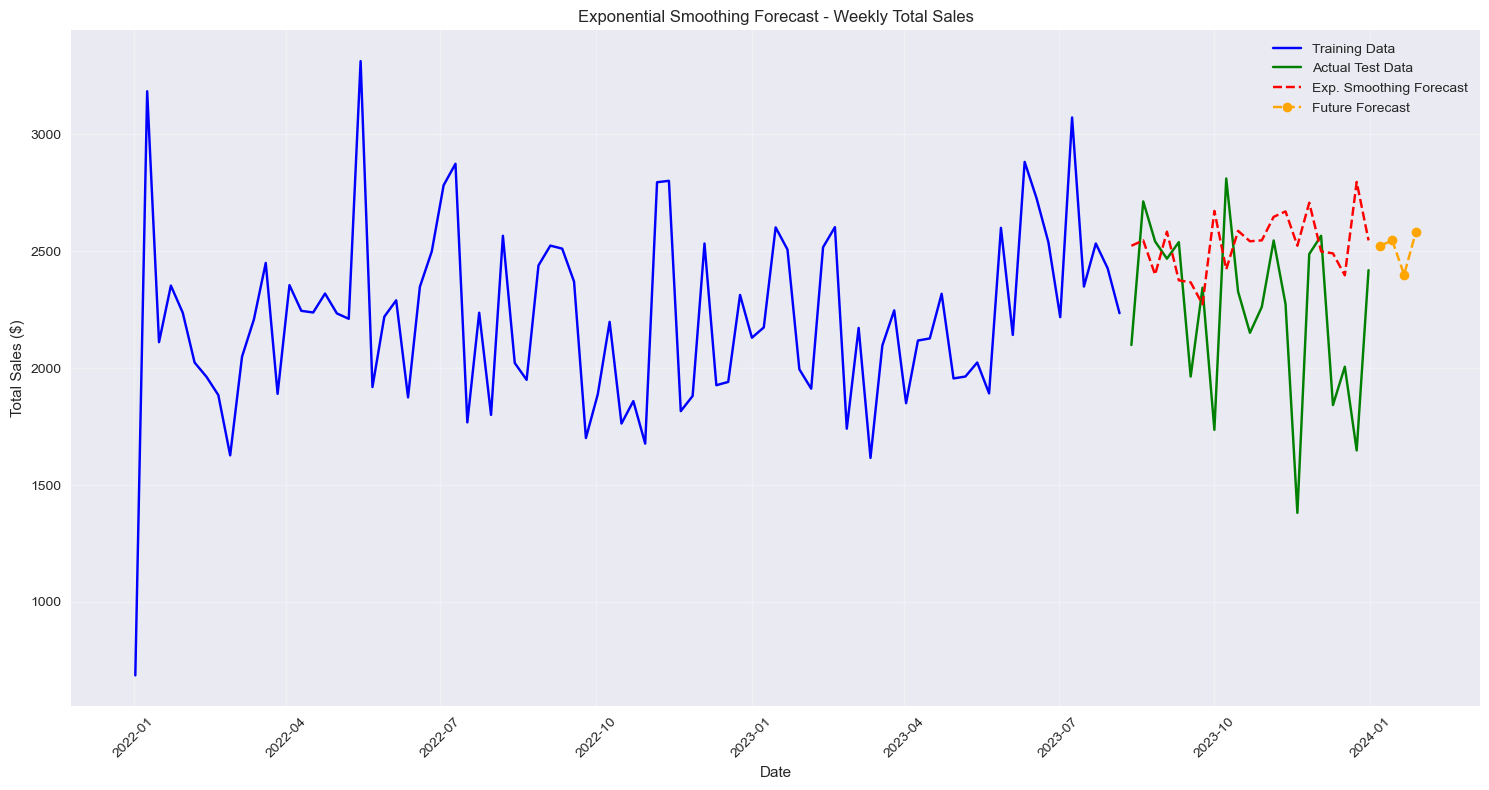


Exponential Smoothing Accuracy:
Mean Squared Error: 247554.88
Mean Absolute Error: 380.38


In [29]:
# Visualize Exponential Smoothing results
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(train_sales.index, train_sales.values, label='Training Data', color='blue')
plt.plot(test_sales.index, test_sales.values, label='Actual Test Data', color='green')

# Plot forecasts
plt.plot(test_sales.index, forecast_sales, label='Exp. Smoothing Forecast', color='red', linestyle='--')

# Future forecasts
future_dates = pd.date_range(start=weekly_sales.index[-1], periods=5, freq='W')[1:]
plt.plot(future_dates, future_sales, label='Future Forecast', color='orange', linestyle='--', marker='o')

plt.title('Exponential Smoothing Forecast - Weekly Total Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate forecast accuracy
mse_exp = mean_squared_error(test_sales, forecast_sales)
mae_exp = mean_absolute_error(test_sales, forecast_sales)
print(f"\nExponential Smoothing Accuracy:")
print(f"Mean Squared Error: {mse_exp:.2f}")
print(f"Mean Absolute Error: {mae_exp:.2f}")

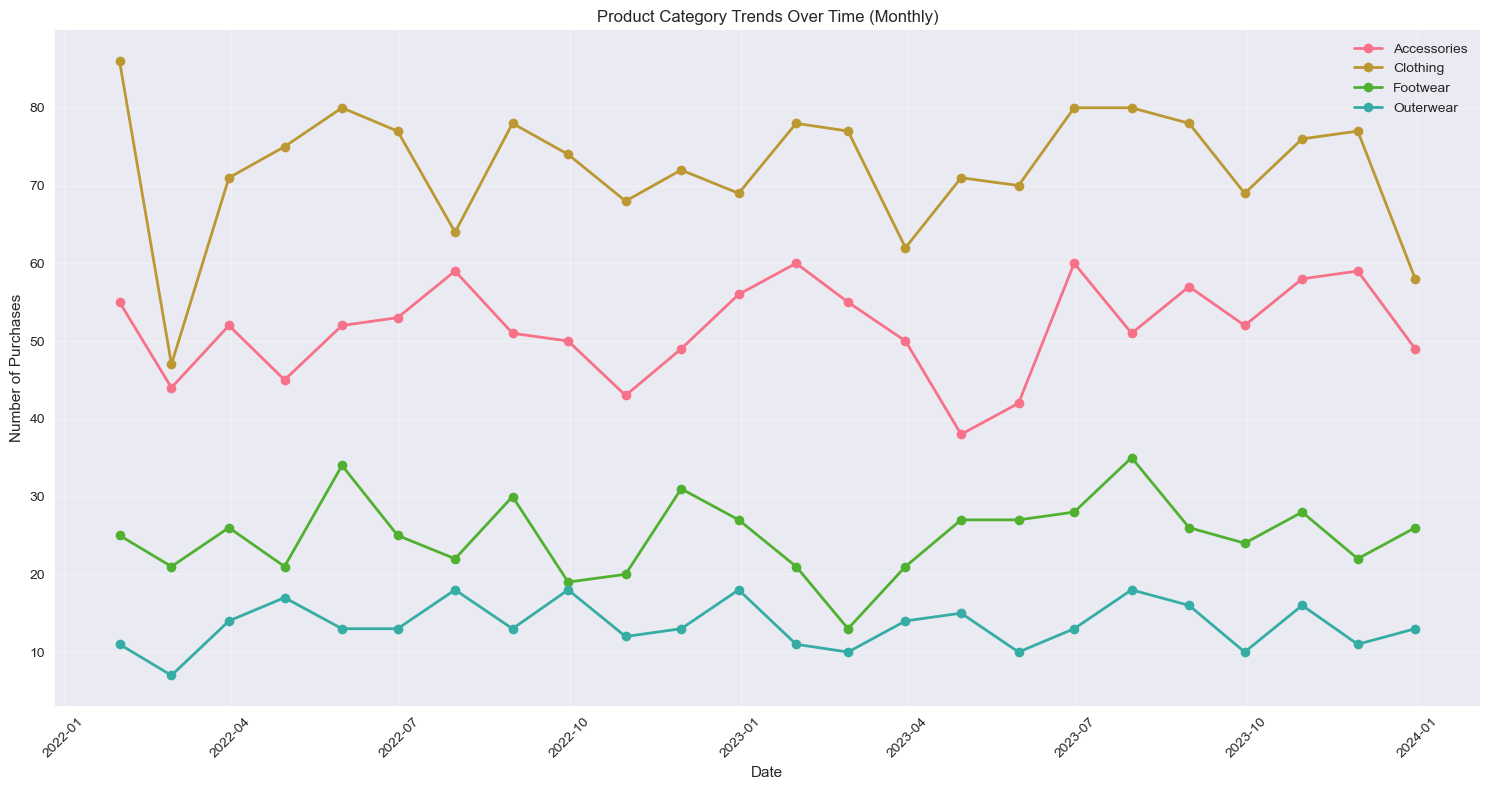

Category distribution over time:
Category  Accessories   Clothing   Footwear  Outerwear
count       24.000000  24.000000  24.000000  24.000000
mean        51.666667  72.375000  24.958333  13.500000
std          6.033722   8.396751   4.947368   3.021661
min         38.000000  47.000000  13.000000   7.000000
25%         49.000000  69.000000  21.000000  11.000000
50%         52.000000  74.500000  25.500000  13.000000
75%         56.250000  78.000000  27.250000  16.000000
max         60.000000  86.000000  35.000000  18.000000


In [30]:
# 7. PRODUCT CATEGORY ANALYSIS OVER TIME

# Analyze product categories over time
category_time = df.groupby(['Purchase_Date', 'Category']).agg({
    'Customer ID': 'count',
    'Purchase Amount (USD)': 'sum'
}).reset_index()

category_time.columns = ['Date', 'Category', 'Count', 'Sales']

# Pivot for easier analysis
category_pivot = category_time.pivot(index='Date', columns='Category', values='Count').fillna(0)

# Resample to monthly data
monthly_categories = category_pivot.resample('M').sum()

# Plot category trends
plt.figure(figsize=(15, 8))
for category in monthly_categories.columns:
    plt.plot(monthly_categories.index, monthly_categories[category], 
             label=category, marker='o', linewidth=2)

plt.title('Product Category Trends Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Category distribution over time:")
print(monthly_categories.describe())

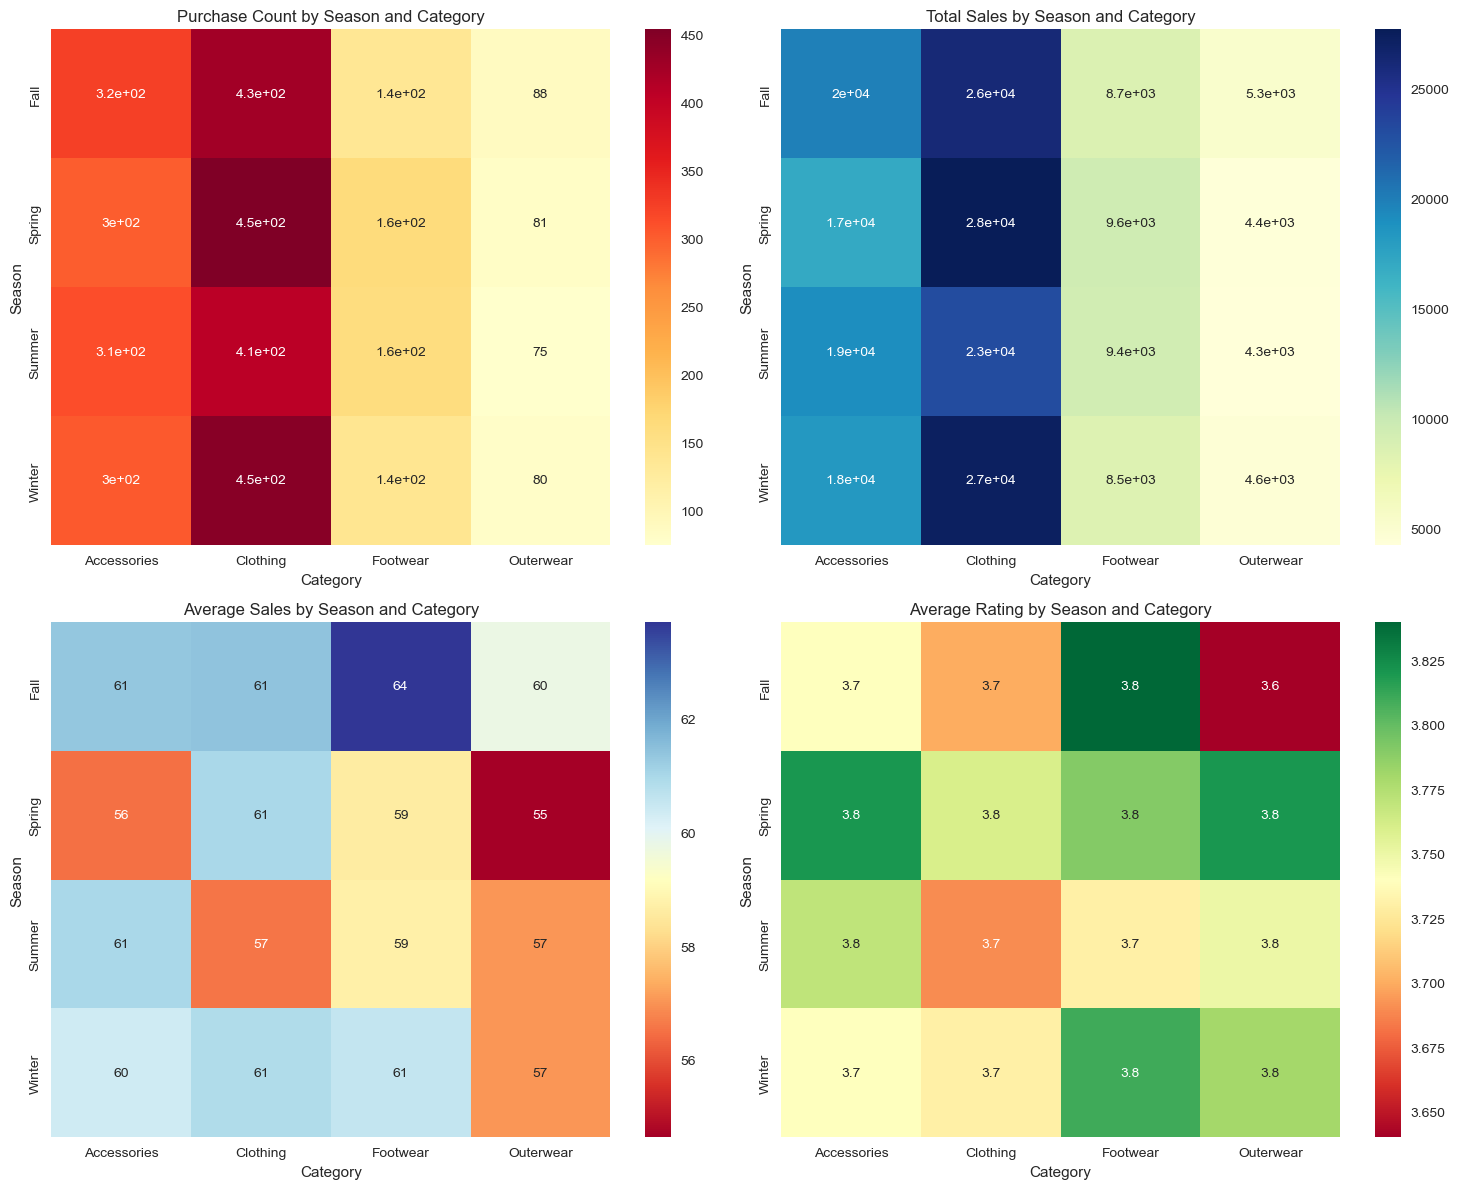

In [31]:
# 8. SEASONAL PATTERNS BY PRODUCT CATEGORY

# Analyze seasonal patterns
df['Season_Numeric'] = df['Season'].map({'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4})

seasonal_analysis = df.groupby(['Season', 'Category']).agg({
    'Customer ID': 'count',
    'Purchase Amount (USD)': ['sum', 'mean'],
    'Review Rating': 'mean'
}).round(2)

seasonal_analysis.columns = ['Count', 'Total_Sales', 'Avg_Sales', 'Avg_Rating']
seasonal_analysis = seasonal_analysis.reset_index()

# Heatmap of seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Purchase count by season and category
pivot_count = seasonal_analysis.pivot(index='Season', columns='Category', values='Count')
sns.heatmap(pivot_count, annot=True, cmap='YlOrRd', ax=axes[0,0])
axes[0,0].set_title('Purchase Count by Season and Category')

# Total sales by season and category
pivot_sales = seasonal_analysis.pivot(index='Season', columns='Category', values='Total_Sales')
sns.heatmap(pivot_sales, annot=True, cmap='YlGnBu', ax=axes[0,1])
axes[0,1].set_title('Total Sales by Season and Category')

# Average sales by season and category
pivot_avg = seasonal_analysis.pivot(index='Season', columns='Category', values='Avg_Sales')
sns.heatmap(pivot_avg, annot=True, cmap='RdYlBu', ax=axes[1,0])
axes[1,0].set_title('Average Sales by Season and Category')

# Average rating by season and category
pivot_rating = seasonal_analysis.pivot(index='Season', columns='Category', values='Avg_Rating')
sns.heatmap(pivot_rating, annot=True, cmap='RdYlGn', ax=axes[1,1])
axes[1,1].set_title('Average Rating by Season and Category')

plt.tight_layout()
plt.show()

In [32]:
# 9. TRAFFIC SIMULATION AND PREDICTION

# Create simulated traffic data based on shopping patterns
# Traffic patterns often correlate with shopping activity

# Generate hourly traffic data
hours = pd.date_range(start='2022-01-01', end='2023-12-31', freq='H')

# Create realistic traffic patterns
np.random.seed(42)

# Base traffic with daily and weekly patterns
base_traffic = 1000  # Base traffic volume
daily_pattern = np.sin(2 * np.pi * np.arange(len(hours)) / 24) * 200  # Daily cycle
weekly_pattern = np.sin(2 * np.pi * np.arange(len(hours)) / (24*7)) * 100  # Weekly cycle
seasonal_pattern = np.sin(2 * np.pi * np.arange(len(hours)) / (24*365)) * 150  # Yearly cycle

# Add noise and shopping correlation
shopping_correlation = np.random.normal(0, 50, len(hours))
noise = np.random.normal(0, 30, len(hours))

# Combine patterns
traffic_volume = (base_traffic + daily_pattern + weekly_pattern + 
                 seasonal_pattern + shopping_correlation + noise)

# Ensure positive values
traffic_volume = np.maximum(traffic_volume, 100)

# Create traffic DataFrame
traffic_df = pd.DataFrame({
    'DateTime': hours,
    'Traffic_Volume': traffic_volume,
    'Hour': hours.hour,
    'DayOfWeek': hours.dayofweek,
    'Month': hours.month,
    'IsWeekend': hours.dayofweek.isin([5, 6]).astype(int)
})

print("Traffic Data Summary:")
print(traffic_df.describe())

Traffic Data Summary:
                  DateTime  Traffic_Volume          Hour     DayOfWeek  \
count                17497    17497.000000  17497.000000  17497.000000   
mean   2022-12-31 12:00:00     1000.023212     11.499343      3.002915   
min    2022-01-01 00:00:00      430.760062      0.000000      0.000000   
25%    2022-07-02 06:00:00      856.662683      5.000000      1.000000   
50%    2022-12-31 12:00:00     1000.482306     11.000000      3.000000   
75%    2023-07-01 18:00:00     1143.806197     17.000000      5.000000   
max    2023-12-31 00:00:00     1585.891990     23.000000      6.000000   
std                    NaN      199.390576      6.922732      2.000126   

              Month     IsWeekend  
count  17497.000000  17497.000000  
mean       6.518832      0.286735  
min        1.000000      0.000000  
25%        4.000000      0.000000  
50%        7.000000      0.000000  
75%       10.000000      1.000000  
max       12.000000      1.000000  
std        3.444495    

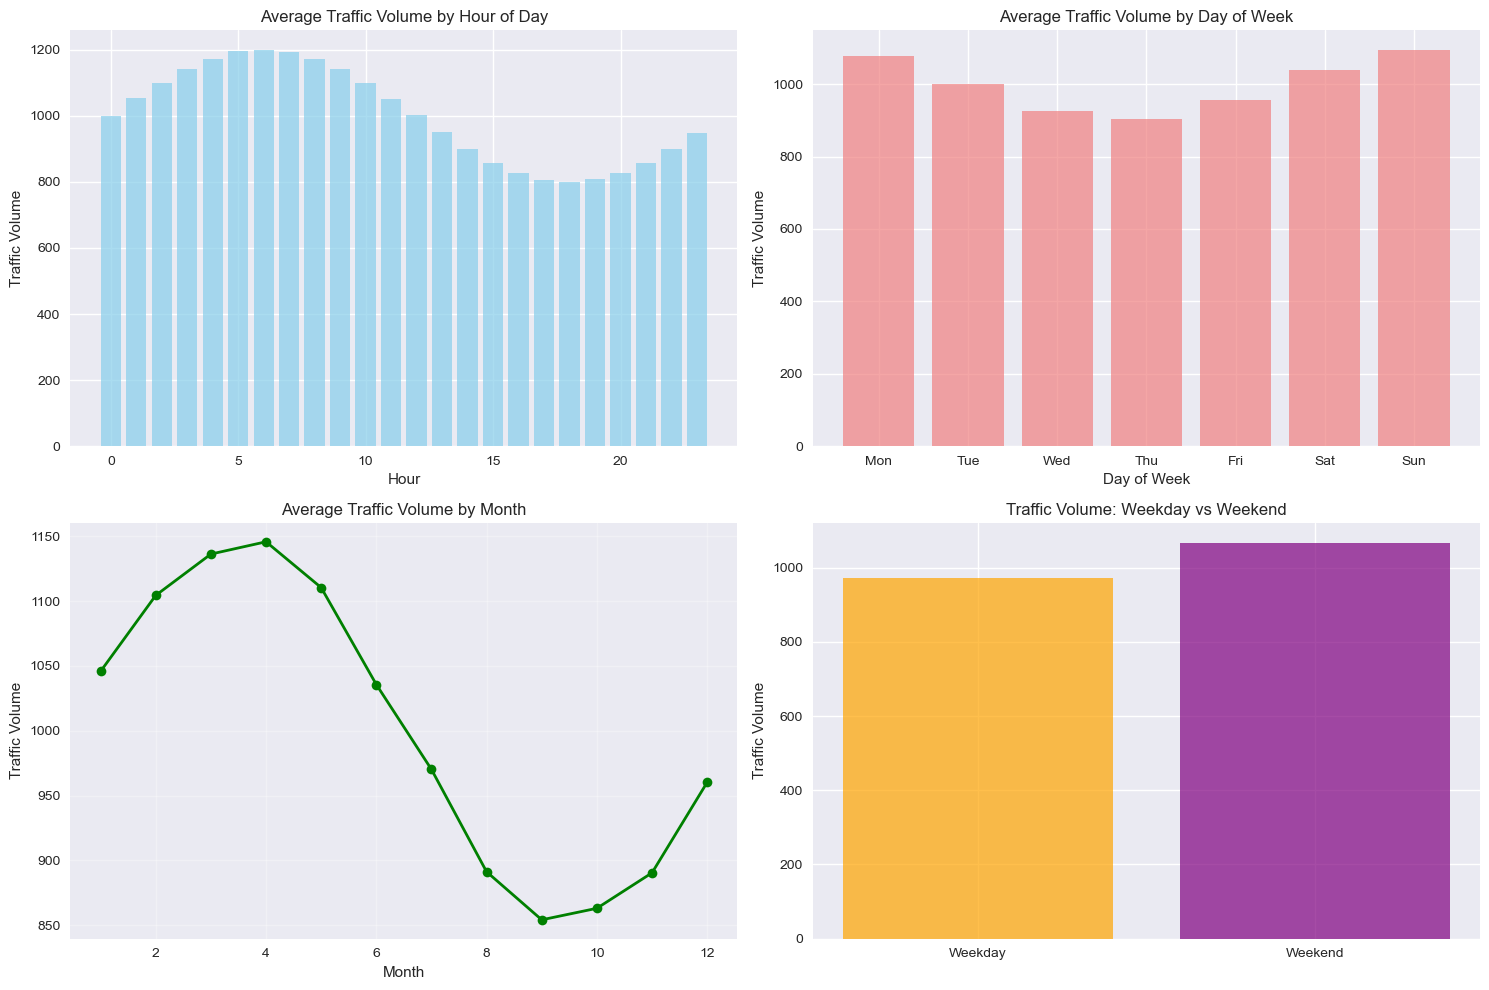

In [33]:
# Visualize traffic patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily traffic pattern (average by hour)
hourly_avg = traffic_df.groupby('Hour')['Traffic_Volume'].mean()
axes[0,0].bar(hourly_avg.index, hourly_avg.values, color='skyblue', alpha=0.7)
axes[0,0].set_title('Average Traffic Volume by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Traffic Volume')

# Weekly pattern (average by day of week)
weekly_avg = traffic_df.groupby('DayOfWeek')['Traffic_Volume'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(range(7), weekly_avg.values, color='lightcoral', alpha=0.7)
axes[0,1].set_title('Average Traffic Volume by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Traffic Volume')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(days)

# Monthly pattern
monthly_avg = traffic_df.groupby('Month')['Traffic_Volume'].mean()
axes[1,0].plot(monthly_avg.index, monthly_avg.values, marker='o', color='green', linewidth=2)
axes[1,0].set_title('Average Traffic Volume by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Traffic Volume')
axes[1,0].grid(True, alpha=0.3)

# Weekend vs Weekday comparison
weekend_comparison = traffic_df.groupby('IsWeekend')['Traffic_Volume'].mean()
axes[1,1].bar(['Weekday', 'Weekend'], weekend_comparison.values, color=['orange', 'purple'], alpha=0.7)
axes[1,1].set_title('Traffic Volume: Weekday vs Weekend')
axes[1,1].set_ylabel('Traffic Volume')

plt.tight_layout()
plt.show()

In [34]:
# 10. TRAFFIC FORECASTING WITH ARIMA

# Aggregate traffic to daily level for forecasting
daily_traffic = traffic_df.set_index('DateTime').resample('D')['Traffic_Volume'].sum()

print(f"Daily traffic data points: {len(daily_traffic)}")
print(f"Date range: {daily_traffic.index.min()} to {daily_traffic.index.max()}")

# Fit ARIMA model for traffic prediction
print("\n=== ARIMA Model for Daily Traffic Volume ===")
arima_traffic, forecast_traffic, future_traffic, train_traffic, test_traffic = fit_arima_model(
    daily_traffic, order=(2,1,2), forecast_steps=7)

print(arima_traffic.summary())

Daily traffic data points: 730
Date range: 2022-01-01 00:00:00 to 2023-12-31 00:00:00

=== ARIMA Model for Daily Traffic Volume ===
                               SARIMAX Results                                
Dep. Variable:         Traffic_Volume   No. Observations:                  584
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4338.992
Date:                Wed, 25 Jun 2025   AIC                           8687.984
Time:                        07:41:42   BIC                           8709.825
Sample:                    01-01-2022   HQIC                          8696.497
                         - 08-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2471      0.000   5633.365      0.000       1.247       1.248

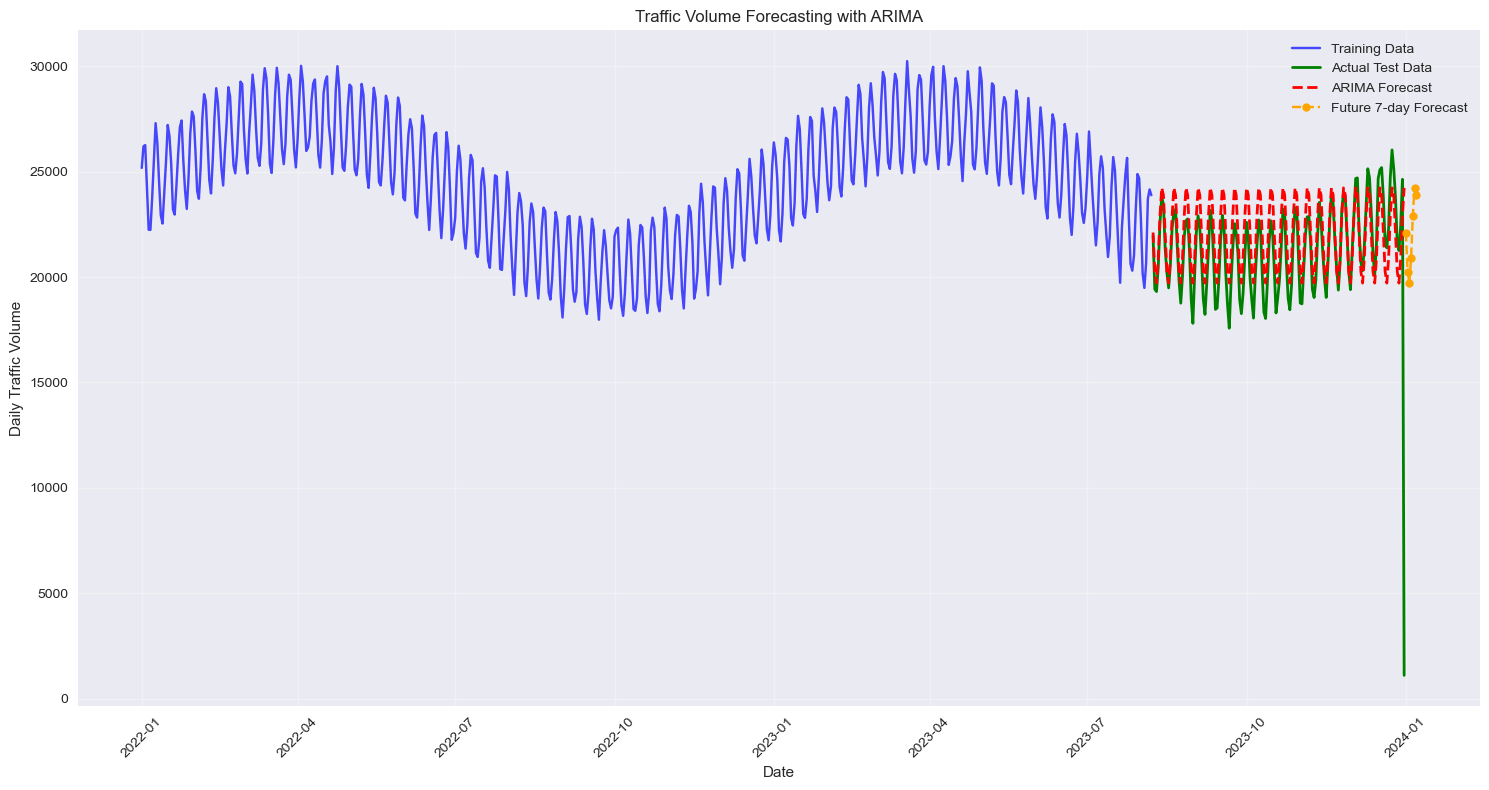


Traffic Forecasting Accuracy:
Mean Squared Error: 5039480.52
Root Mean Squared Error: 2244.88
Mean Absolute Error: 1196.49
Mean Absolute Percentage Error: 5.64%


In [35]:
# Visualize traffic forecasting results
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(train_traffic.index, train_traffic.values, label='Training Data', color='blue', alpha=0.7)
plt.plot(test_traffic.index, test_traffic.values, label='Actual Test Data', color='green', linewidth=2)

# Plot forecasts
plt.plot(test_traffic.index, forecast_traffic, label='ARIMA Forecast', color='red', linestyle='--', linewidth=2)

# Future forecasts (next 7 days)
future_dates = pd.date_range(start=daily_traffic.index[-1], periods=8, freq='D')[1:]
plt.plot(future_dates, future_traffic, label='Future 7-day Forecast', 
         color='orange', linestyle='--', marker='o', markersize=6)

plt.title('Traffic Volume Forecasting with ARIMA')
plt.xlabel('Date')
plt.ylabel('Daily Traffic Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate accuracy metrics
mse_traffic = mean_squared_error(test_traffic, forecast_traffic)
mae_traffic = mean_absolute_error(test_traffic, forecast_traffic)
rmse_traffic = np.sqrt(mse_traffic)

print(f"\nTraffic Forecasting Accuracy:")
print(f"Mean Squared Error: {mse_traffic:.2f}")
print(f"Root Mean Squared Error: {rmse_traffic:.2f}")
print(f"Mean Absolute Error: {mae_traffic:.2f}")
print(f"Mean Absolute Percentage Error: {(mae_traffic/test_traffic.mean())*100:.2f}%")

Correlation Matrix:
                Traffic_Volume  Shopping_Count  Shopping_Sales
Traffic_Volume             NaN             NaN             NaN
Shopping_Count             NaN             NaN             NaN
Shopping_Sales             NaN             NaN             NaN


<Figure size 1200x800 with 0 Axes>

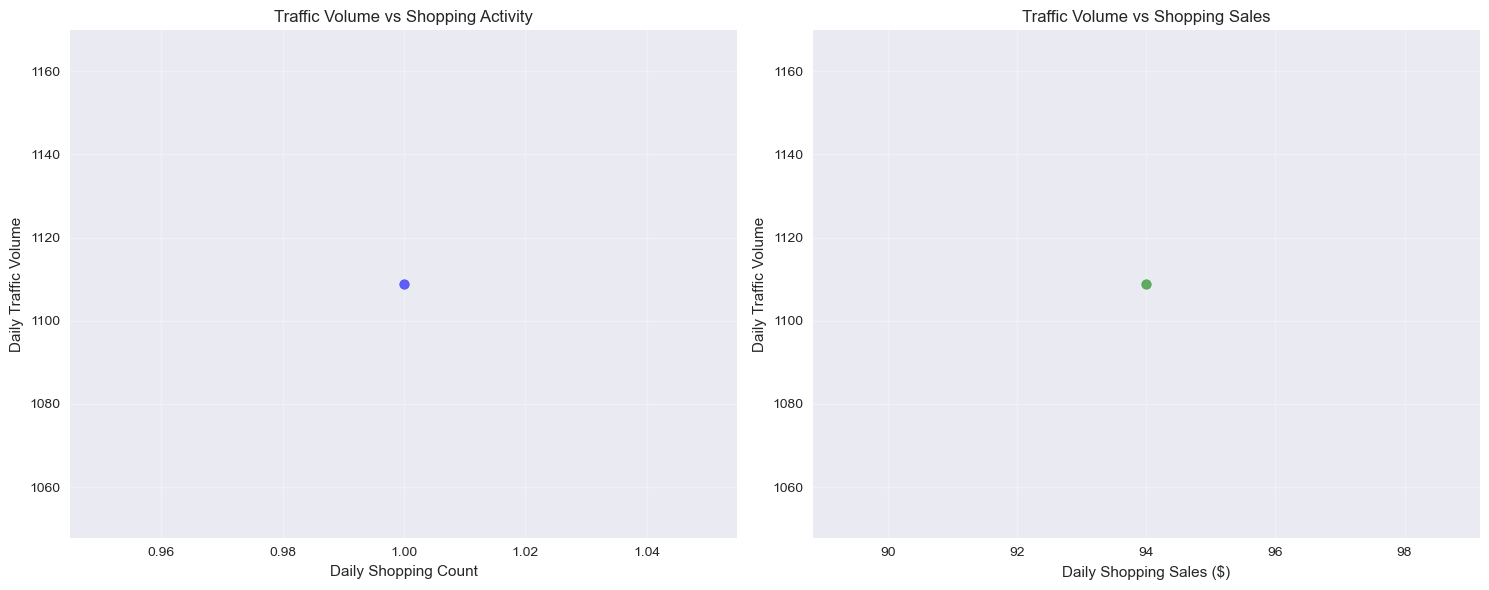

In [36]:
# 11. ADVANCED TRAFFIC PATTERN ANALYSIS

# Correlation between shopping activity and traffic
# Resample shopping data to daily for comparison
daily_shopping = df.groupby('Purchase_Date').agg({
    'Customer ID': 'count',
    'Purchase Amount (USD)': 'sum'
}).reset_index()

daily_shopping.columns = ['Date', 'Shopping_Count', 'Shopping_Sales']
daily_shopping.set_index('Date', inplace=True)

# Merge with traffic data (align dates)
merged_data = pd.merge(daily_traffic.to_frame('Traffic_Volume'), 
                      daily_shopping, 
                      left_index=True, right_index=True, how='inner')

# Calculate correlation
correlation = merged_data.corr()
print("Correlation Matrix:")
print(correlation)

# Visualize correlation
plt.figure(figsize=(12, 8))

# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Traffic vs Shopping Count
axes[0].scatter(merged_data['Shopping_Count'], merged_data['Traffic_Volume'], 
               alpha=0.6, color='blue')
axes[0].set_xlabel('Daily Shopping Count')
axes[0].set_ylabel('Daily Traffic Volume')
axes[0].set_title('Traffic Volume vs Shopping Activity')
axes[0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(merged_data['Shopping_Count'], merged_data['Traffic_Volume'], 1)
p = np.poly1d(z)
axes[0].plot(merged_data['Shopping_Count'], p(merged_data['Shopping_Count']), 
            "r--", alpha=0.8, linewidth=2)

# Traffic vs Shopping Sales
axes[1].scatter(merged_data['Shopping_Sales'], merged_data['Traffic_Volume'], 
               alpha=0.6, color='green')
axes[1].set_xlabel('Daily Shopping Sales ($)')
axes[1].set_ylabel('Daily Traffic Volume')
axes[1].set_title('Traffic Volume vs Shopping Sales')
axes[1].grid(True, alpha=0.3)

# Add trend line
z2 = np.polyfit(merged_data['Shopping_Sales'], merged_data['Traffic_Volume'], 1)
p2 = np.poly1d(z2)
axes[1].plot(merged_data['Shopping_Sales'], p2(merged_data['Shopping_Sales']), 
            "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

Model Performance Comparison:
     Metric  ARIMA_Transactions  ExpSmoothing_Sales  ARIMA_Traffic
0       MSE               39.99           247554.88     5039480.52
1       MAE                5.51              380.38        1196.49
2      RMSE                6.32              497.55        2244.88
3  MAPE (%)               14.58               16.95           5.64


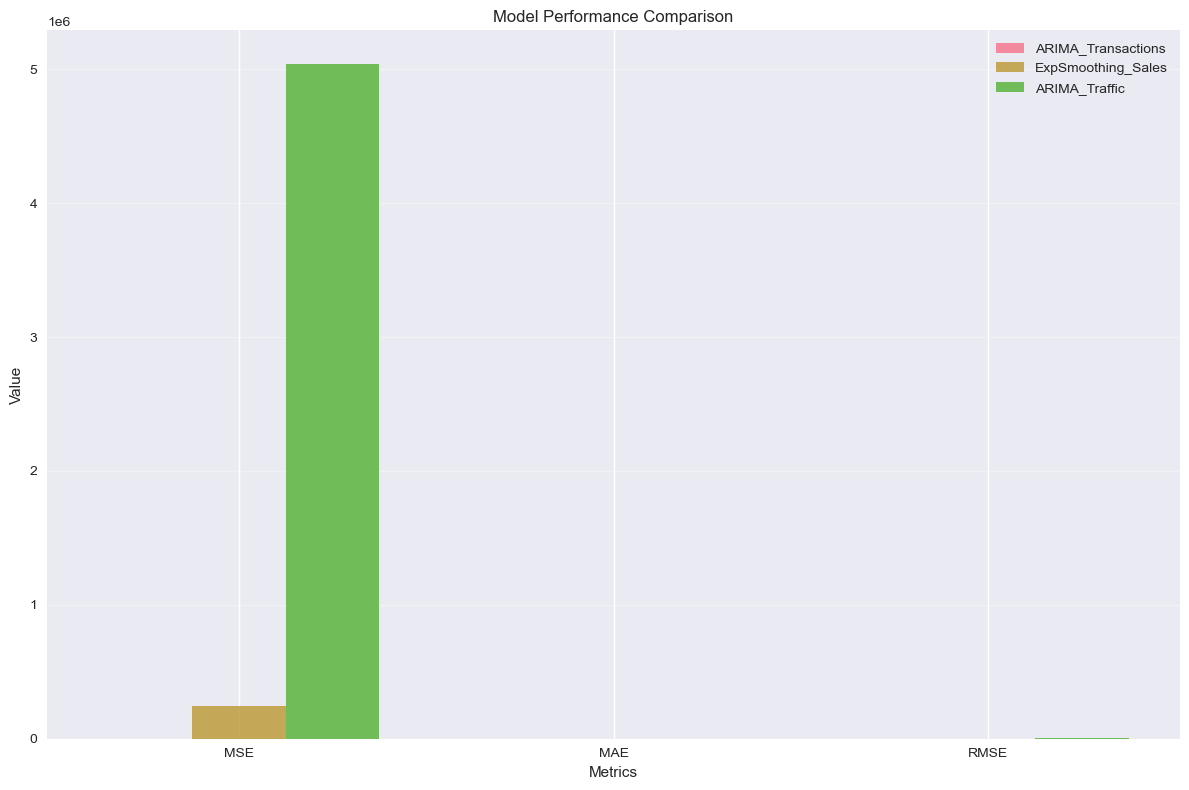

In [37]:
# 12. MODEL COMPARISON AND EVALUATION

# Compare different forecasting models
models_performance = {
    'Metric': ['MSE', 'MAE', 'RMSE', 'MAPE (%)'],
    'ARIMA_Transactions': [mse, mae, np.sqrt(mse), (mae/test_trans.mean())*100],
    'ExpSmoothing_Sales': [mse_exp, mae_exp, np.sqrt(mse_exp), (mae_exp/test_sales.mean())*100],
    'ARIMA_Traffic': [mse_traffic, mae_traffic, rmse_traffic, (mae_traffic/test_traffic.mean())*100]
}

performance_df = pd.DataFrame(models_performance)
print("Model Performance Comparison:")
print(performance_df.round(2))

# Visualize model performance
plt.figure(figsize=(12, 8))

metrics = ['MSE', 'MAE', 'RMSE']
models = ['ARIMA_Transactions', 'ExpSmoothing_Sales', 'ARIMA_Traffic']

x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(models):
    values = performance_df[model][:3].values  # First 3 metrics
    plt.bar(x + i*width, values, width, label=model, alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Comparison')
plt.xticks(x + width, metrics)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [38]:
# 13. BUSINESS INSIGHTS AND RECOMMENDATIONS

print("="*60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)

# Peak shopping times
peak_hours = traffic_df.groupby('Hour')['Traffic_Volume'].mean().nlargest(3)
print(f"\n1. PEAK TRAFFIC HOURS:")
for hour, volume in peak_hours.items():
    time_label = f"{hour:02d}:00"
    print(f"   - {time_label}: {volume:.0f} average volume")

# Seasonal insights
seasonal_insights = df.groupby('Season').agg({
    'Purchase Amount (USD)': 'mean',
    'Review Rating': 'mean',
    'Customer ID': 'count'
}).round(2)

print(f"\n2. SEASONAL PATTERNS:")
for season in seasonal_insights.index:
    avg_sale = seasonal_insights.loc[season, 'Purchase Amount (USD)']
    avg_rating = seasonal_insights.loc[season, 'Review Rating']
    count = seasonal_insights.loc[season, 'Customer ID']
    print(f"   - {season}: Avg Sale=${avg_sale}, Rating={avg_rating}, Count={count}")

# Category performance
category_performance = df.groupby('Category').agg({
    'Purchase Amount (USD)': ['mean', 'sum'],
    'Review Rating': 'mean',
    'Customer ID': 'count'
}).round(2)

category_performance.columns = ['Avg_Sale', 'Total_Sales', 'Avg_Rating', 'Count']
category_performance = category_performance.sort_values('Total_Sales', ascending=False)

print(f"\n3. TOP PERFORMING CATEGORIES:")
for i, (category, row) in enumerate(category_performance.head(3).iterrows()):
    print(f"   {i+1}. {category}: Total=${row['Total_Sales']:.0f}, Avg=${row['Avg_Sale']}, Rating={row['Avg_Rating']}")

# Future forecasts summary
print(f"\n4. FORECASTING PREDICTIONS:")
print(f"   - Next week transaction forecast: {future_trans.mean():.0f} transactions/week")
print(f"   - Next week sales forecast: ${future_sales.mean():.0f}/week")
print(f"   - Next 7 days traffic forecast: {future_traffic.mean():.0f} volume/day")

# Recommendations
print(f"\n5. STRATEGIC RECOMMENDATIONS:")
print(f"   - Optimize inventory during peak hours ({peak_hours.index[0]}:00-{peak_hours.index[0]+2}:00)")
print(f"   - Focus marketing on {seasonal_insights['Purchase Amount (USD)'].idxmax()} season")
print(f"   - Promote {category_performance.index[0]} category for highest revenue")
print(f"   - Monitor traffic patterns for resource allocation")
print(f"   - Implement dynamic pricing during high-traffic periods")

BUSINESS INSIGHTS AND RECOMMENDATIONS

1. PEAK TRAFFIC HOURS:
   - 06:00: 1199 average volume
   - 05:00: 1196 average volume
   - 07:00: 1194 average volume

2. SEASONAL PATTERNS:
   - Fall: Avg Sale=$61.56, Rating=3.73, Count=975
   - Spring: Avg Sale=$58.74, Rating=3.79, Count=999
   - Summer: Avg Sale=$58.41, Rating=3.73, Count=955
   - Winter: Avg Sale=$60.36, Rating=3.75, Count=971

3. TOP PERFORMING CATEGORIES:
   1. Clothing: Total=$104264, Avg=$60.03, Rating=3.72
   2. Accessories: Total=$74200, Avg=$59.84, Rating=3.77
   3. Footwear: Total=$36093, Avg=$60.26, Rating=3.79

4. FORECASTING PREDICTIONS:
   - Next week transaction forecast: 37 transactions/week
   - Next week sales forecast: $2513/week
   - Next 7 days traffic forecast: 22003 volume/day

5. STRATEGIC RECOMMENDATIONS:
   - Optimize inventory during peak hours (6:00-8:00)
   - Focus marketing on Fall season
   - Promote Clothing category for highest revenue
   - Monitor traffic patterns for resource allocation
   - 

In [40]:
# 14. SAVE RESULTS AND GENERATE REPORT

# Create summary statistics
summary_stats = {
    'Dataset_Overview': {
        'Total_Records': len(df),
        'Date_Range': f"{df['Purchase_Date'].min()} to {df['Purchase_Date'].max()}",
        'Total_Revenue': df['Purchase Amount (USD)'].sum(),
        'Average_Transaction': df['Purchase Amount (USD)'].mean(),
        'Unique_Customers': df['Customer ID'].nunique()
    },
    
    'Time_Series_Metrics': {
        'Daily_Avg_Transactions': daily_sales['Transaction_Count'].mean(),
        'Weekly_Avg_Sales': weekly_sales['Total_Sales'].mean(),
        'Traffic_Daily_Avg': daily_traffic.mean(),
        'Peak_Traffic_Hour': traffic_df.groupby('Hour')['Traffic_Volume'].mean().idxmax()
    },
    
    'Forecasting_Accuracy': {
        'ARIMA_Transactions_MAPE': f"{(mae/test_trans.mean())*100:.2f}%",
        'ExpSmoothing_Sales_MAPE': f"{(mae_exp/test_sales.mean())*100:.2f}%",
        'ARIMA_Traffic_MAPE': f"{(mae_traffic/test_traffic.mean())*100:.2f}%"
    }
}

# Display final summary
print("\n" + "="*60)
print("FINAL ANALYSIS SUMMARY")
print("="*60)

for section, metrics in summary_stats.items():
    print(f"\n{section.replace('_', ' ').upper()}:")
    for metric, value in metrics.items():
        print(f"  - {metric.replace('_', ' ')}: {value}")


FINAL ANALYSIS SUMMARY

DATASET OVERVIEW:
  - Total Records: 3900
  - Date Range: 2022-01-01 04:29:14.295973326 to 2023-12-31 00:00:00
  - Total Revenue: 233081
  - Average Transaction: 59.76435897435898
  - Unique Customers: 3900

TIME SERIES METRICS:
  - Daily Avg Transactions: 1.6069221260815822
  - Weekly Avg Sales: 2219.8190476190475
  - Traffic Daily Avg: 23969.04951766204
  - Peak Traffic Hour: 6

FORECASTING ACCURACY:
  - ARIMA Transactions MAPE: 14.58%
  - ExpSmoothing Sales MAPE: 16.95%
  - ARIMA Traffic MAPE: 5.64%
